In [18]:
import sys
sys.path.append('..')

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from typing import List
import numpy as np
from tqdm.notebook import trange as trange
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from utils.data_utils import *
from test_framework.model_interface import ModelInterface
from test_framework.tester import Tester
from test_framework.metrics import *
from active_learning.categorical_query_functions import *
from active_learning.gradient_embedding import compute_gradient_embeddings
from active_learning.cluster_margin import *

from models.unimodal.softmax_regression import *

## Dataset and Model Constants

In [21]:
# Data Constants
DATA_DIR = "../data/kaggle_satellite_image_classification"
NUM_CLASSES = 4
MAIN_IMG_DIMS = (64, 64)
SECONDARY_IMG_DIMS = (32, 32)
MAX_SECONDARY_IMAGES = 5

# Model Constants
FINAL_LAYER_LEN = 64

# Training Constants
TEST_DATA_FRACTION = 0.05

## Load Dataset, creating secondary modality

0.61796266
Label = [1. 0. 0. 0.]


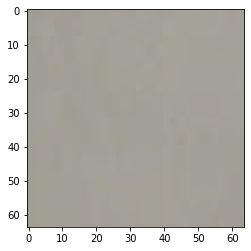

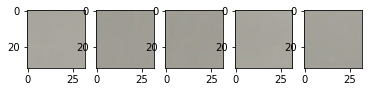

Label = [0. 0. 1. 0.]


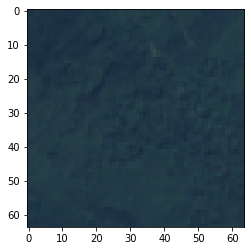

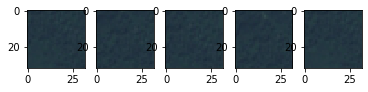

Label = [0. 0. 1. 0.]


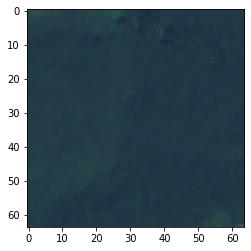

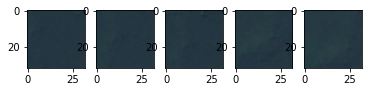

Label = [0. 1. 0. 0.]


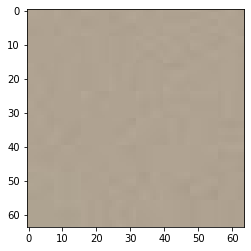

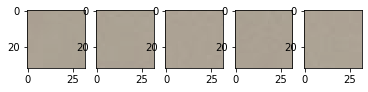

In [22]:
def load_dataset_as_numpy(max_samples: int = None):
    def transform_to_multimodal(image):
        main_image = transforms.Compose([
            transforms.CenterCrop(MAIN_IMG_DIMS),
            transforms.ToTensor(),
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(image.copy())

        secondary_images = [
            transforms.Compose([
                transforms.RandomCrop(SECONDARY_IMG_DIMS),
                transforms.ToTensor(),
                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                transforms.Lambda(lambda img: transforms.functional.adjust_contrast(img, contrast_factor=0.8))
            ])(image.copy()) for i in range(MAX_SECONDARY_IMAGES)
        ]
        secondary_images = torch.stack(secondary_images)
        
        return main_image, secondary_images

    dataset = datasets.ImageFolder(DATA_DIR, transform=transform_to_multimodal)
    output_sample_count = len(dataset) if max_samples is None or max_samples >= len(dataset) else max_samples
    all_data_dataloader = torch.utils.data.DataLoader(dataset, batch_size=output_sample_count, num_workers=0, shuffle=True)
    (main_image_all, secondary_images_all), y_all = next(iter(all_data_dataloader))

    # Convert y to one-hot array
    y_all = torch.eye(NUM_CLASSES)[y_all]

    return main_image_all.numpy(), secondary_images_all.numpy(), y_all.numpy()

x_main, x_secondary, y = load_dataset_as_numpy()


# Display some examples
print(np.mean(x_main[0]))
for i in range(4):
    print(f"Label = {y[i]}")
    plt.imshow(x_main[i].transpose(1, 2, 0))
    plt.show()
    fig, axarr = plt.subplots(1, MAX_SECONDARY_IMAGES)
    for j in range(MAX_SECONDARY_IMAGES):
        axarr[j].imshow(x_secondary[i][j].transpose(1, 2, 0))
    plt.show()
plt.close('all')

## Try a linear model

In [23]:
from models.unimodal.softmax_regression import *


test_model = SoftmaxRegression()

In [24]:
# split dataset
def train_test_split(x, shuffle_indices, train_percentage):
    # np.random.shuffle(x)
    x = x[shuffle_indices]
    print(x.shape)
    print(x[:int(x.shape[0]*train_percentage)].shape)
    return x[:int(x.shape[0]*train_percentage)], x[int(x.shape[0]*train_percentage):]

shuffle_indices = np.random.permutation(x_main.shape[0])
x_main_train, x_main_test = train_test_split(x_main, shuffle_indices, 0.7)
x_secondary_train, x_secondary_test = train_test_split(x_secondary, shuffle_indices, 0.7)
y_train, y_test = train_test_split(y, shuffle_indices, 0.7)

(4624, 3, 64, 64)
(3236, 3, 64, 64)
(4624, 5, 3, 32, 32)
(3236, 5, 3, 32, 32)
(4624, 4)
(3236, 4)


In [52]:
print(y_train.shape)
new_y_train = np.where(y_train==1)[-1]
print(x_main_train.shape)
print(new_y_train.shape)
#print(y[:10])
#print(np.where(y==1)[-1][:10])

(3236, 4)
(3236, 3, 64, 64)
(3236,)


In [55]:
from sklearn import preprocessing

x_main_train = x_main_train.reshape(x_main_train.shape[0], -1)
scaler = preprocessing.StandardScaler().fit(x_main_train)
x_main_train_scaled = scaler.transform(x_main_train)

In [56]:
test_model.train(x_main_train_scaled, new_y_train)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [63]:
#print(test_model.classes_)
x_main_test = x_main_test.reshape(x_main_test.shape[0], -1)
scaler = preprocessing.StandardScaler().fit(x_main_test)
x_main_test_scaled = scaler.transform(x_main_test)
preds = test_model.predict(x_main_test_scaled)

In [64]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce


n_values = 4
preds = np.eye(n_values)[preds]

#preds = preds[np.arange(preds.shape[-1]), preds]=1


print(cross_entropy(y_test, preds))

3.105354155174937
